# Overview

This notebook defines how to choose the right parameters to filter the duplicated images. Implement a grid search and as a metric use a number of images that where deleted from a folder (`dataset`).

In [1]:
from pathlib import Path

import imagesize
import pandas as pd


max_width = 0
max_height = 0

sizes = []


for image_path in Path("dataset").iterdir():
    if image_path.is_dir():
        continue
    w, h = imagesize.get(str(image_path))
    sizes.append({"width": w, "height": h})
    max_width = max(max_width, w)
    max_height = max(max_height, h)

print(f"max size: ({max_width},{max_height})")

max_area = max_width * max_height
print(f"max_area: {max_area}")

sizes = pd.DataFrame(sizes)

max size: (2688,1520)
max_area: 4085760


As you could see, the images in the dataset has different sizes, until images are scaled, there is no much sense to apply same `area` and `score` thresholds to all images. 

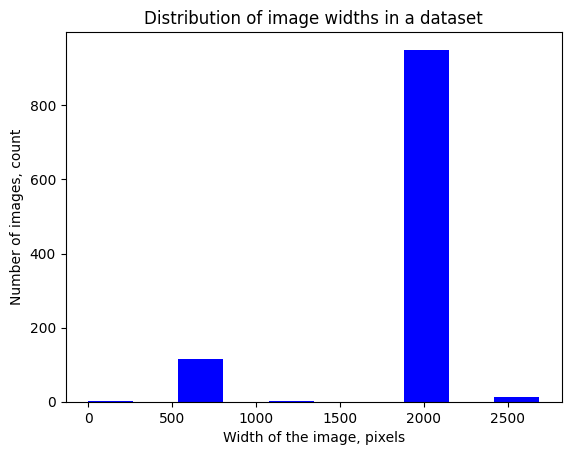

In [2]:
from matplotlib import pyplot as P

fig, ax = P.subplots()

ax.hist(sizes["width"], color="blue")
ax.set_xlabel("Width of the image, pixels")
ax.set_ylabel("Number of images, count")

_ = ax.set_title("Distribution of image widths in a dataset")

Use geometric space to allocate the parameters for the experiment.

In [3]:
import pandas as pd
import numpy as np

from imagedup.duplicates import ImageDupFinder

areas = np.geomspace(16, max_area/4, num=10)
scores = np.geomspace(16, max_area/4, num=10)

results = []

for min_score in scores:
    for min_area in areas:
        dp = ImageDupFinder("dataset", min_score, min_area)
        results.append({"score": min_score, "area": min_area, "num_dup": len(list(dp))})
        print(".", end="")

print("completed")
data = pd.DataFrame(results)
data

....................................................................................................completed


,score,area,num_dup
0,16.0,1.600000e+01,113
1,16.0,5.470401e+01,236
2,16.0,1.870331e+02,295
3,16.0,6.394662e+02,338
4,16.0,2.186336e+03,395
...,...,...,...
95,1021440.0,7.475083e+03,958
96,1021440.0,2.555732e+04,965
97,1021440.0,8.738048e+04,967
98,1021440.0,2.987539e+05,993


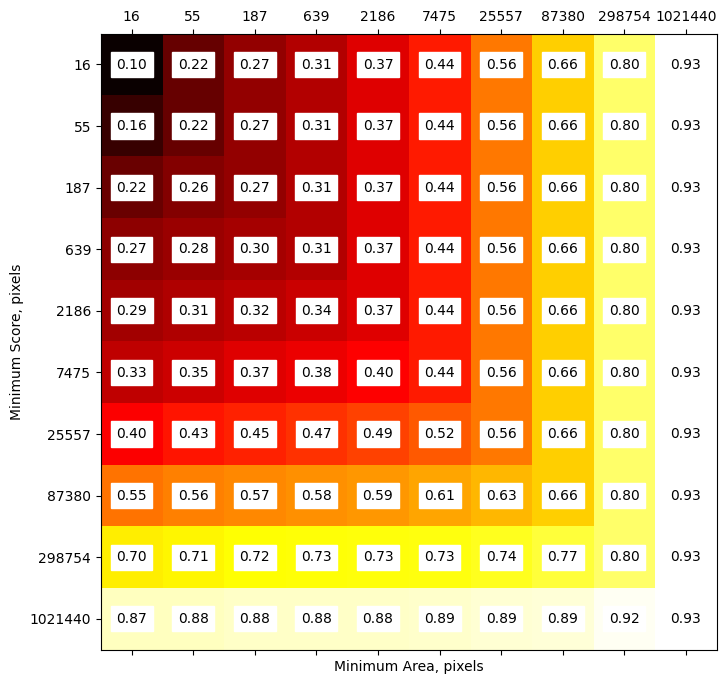

In [5]:
from matplotlib import pyplot as P

NUM_IMG = 1081.0

fig, ax = P.subplots()

data["score"] = data["score"].astype(np.int32)
data["area"] = data["area"].astype(np.int32)

num_dup = data["num_dup"].to_numpy()
num_dup = np.reshape(num_dup, (10, 10))
num_dup = num_dup / NUM_IMG

im = ax.matshow(num_dup, cmap="hot")
im.figure.set_size_inches((8, 8))
im.axes.set_yticks(range(10), labels=np.round(scores).astype(np.int32))
im.axes.set_xticks(range(10), labels=np.round(areas).astype(np.int32))
im.axes.set_xlabel("Minimum Area, pixels")
im.axes.set_ylabel("Minimum Score, pixels")


for (i, j), dups in np.ndenumerate(num_dup):
    ax.text(
        j, i,
        "{:.2f}".format(dups), ha="center", va="center",
        bbox=dict(facecolor="white", edgecolor="1"),
    )

Since we don't clearly know the expectation of what balance of change size vs. number of duplicates we want to maintain. We could choose parameters that define 50% of images beign removed.